## Agenda

* Intro
  * What is Theano and why should I care?
  * Installation
  * Configuration
* Basics
  * Baby steps
  * Theano variables and functions
  * Shared variables and more on functions
  * Debugging
* Theano for Machine Learning
  * Logistic regression
  * SVM
  * Kernels
  * Regularization
  * Multilayer perceptron
* Lasagne
  * MLP revisited
  * Convolutional neural network
  * Goodies (?)


Код доступен тут: https://github.com/dudevil/datafest-theano-tutorial/.

## Intro

Theano позволяет с помощью языка Python определять, компилировать и вычислять математические выражения.
Так что Theano это сразу много вещей:

* Язык для символьных вычислений
* Оптимизирующий компилятор
* Средства исполнения кода

## Установка

Зависимости:
   
   Системные: **g++, BLAS**
   
   Python: **NumPy, SciPy** 
   
   Goodies: **CUDA, CuDNN**

Последний релиз:
```
pip install Theano
```

Bleeding-edge:
```
pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
```

## Configuration

~/.theanorc

```
    [global]
    device = gpu # cpu
    floatX = float32
    optimizer_including=cudnn 
    allow_gc = False # быстрее но использует больше памяти
    #optimizer = None  # полезно при отладке
    #profile = True
    #profile_memory = True

    [nvcc]
    fastmath = True
```

[More](http://deeplearning.net/software/theano/library/config.html)

## Basic operatins

### Baby steps

In [1]:
import theano 
import theano.tensor as T

import numpy as np
%pylab inline
figsize(8, 6)

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 980


In [12]:
# doing stuff with theano

# declare theano variable
a = theano.tensor.lscalar() 

# construct an expression
expression = 1 + 2 * a + a ** 2 

# compile a theano function
f = theano.function(
    inputs=[a],        # input
    outputs=expression  # output
)

# evaluate the expression
f(10)

array(121)

### Theano variables and functions

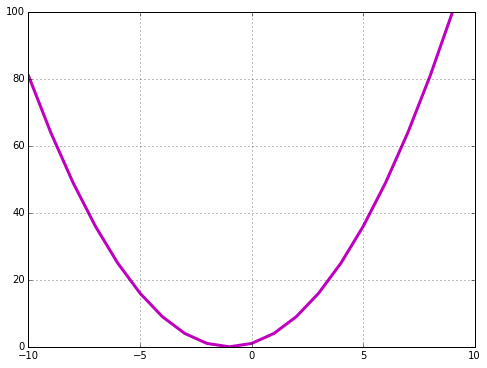

In [14]:
# only the declaration changes
a = theano.tensor.lvector()

expression = 1 + 2 * a + a ** 2 

f = theano.function(
    [a],        # input
    expression  # output
)

arg = np.arange(-10, 10)
res = f(arg)

plot(arg, res, c='m', linewidth=3.)
grid()

In [23]:
# can do the same with matrices
x = T.dmatrix('x')
y = T.dmatrix('y')

z = x + 2 * y

f = theano.function([x, y], z)
f(np.ones((3, 3)), np.eye(3))

array([[ 3.,  1.,  1.],
       [ 1.,  3.,  1.],
       [ 1.,  1.,  3.]])

In [5]:
# broadcasting also works
x = T.dmatrix('x')
v = T.dvector('v')

z = v + x

f = theano.function([x, v], z)
f(np.ones((3, 4)), np.ones((4,)))

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.]])

In [21]:
# types should be handled with care
x = T.fmatrix('x')
v = T.fvector('v')

z = v + x

f = theano.function(
    [x, v],
    z,
)
print f(np.ones((3, 4), dtype=np.float32), np.ones((4,), dtype=np.float32))
print f(np.ones((3, 4)), np.ones((4,)))

[[ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]]


TypeError: ('Bad input argument to theano function with name "<ipython-input-21-7caf284083b2>:9"  at index 0(0-based)', 'TensorType(float32, matrix) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function".', array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]]))

In [22]:
# or you can supress the exception
x = T.fmatrix('x')
v = T.fvector('v')

z = v + x

f = theano.function(
    [x, v],
    z,
    allow_input_downcast=True
)
print f(np.ones((3, 4), dtype=np.float64), np.ones((4,), dtype=np.float64))

[[ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]]


### Shared variables and more on functions

In [54]:
# shared variables represent internal state
state = theano.shared(0)

i = T.iscalar('i')
inc = theano.function([i],
                      state,
                      # updates the shared variable value
                      updates=[(state, state+i)]) 
dec = theano.function([i],
                      state,
                      updates=[(state, state-i)])

# more than one function can update the shared variable
print state.get_value()
inc(1)
inc(1)
inc(1)
print state.get_value()
dec(2)
print state.get_value()

0
3
1


In [43]:
# we can also set the shared variable outside of the function
state.set_value(-15)
print state.get_value()

-15


In [57]:
# shared variables can in be inserted into the compurational graph
x = T.lscalar('x')
y = T.lscalar('y')
i = T.lscalar('i')

expression = (x - y) ** 2

state = theano.shared(0)

f = theano.function(
    [x, i],
    expression,
    updates=[(state, state+i)],
    # use the value at state as y
    givens={
        y : state
    }
)
print f(5, 1) # (5 - 0) ^ 2 = 25
print f(2, 1) # (2 - 1) ^ 2 = 1

25
1


In [36]:
# we can compute different outputs simultaneously
x = T.lscalar('x')
y = T.lscalar('y')

square = T.square(x + y)
sqrt = T.sqrt(x + y)

f = theano.function(
    [x, y],
    [square, sqrt]
)
print f(5, 4)
print f(2, 2)

[array(81), array(3.0)]
[array(16), array(2.0)]


## Debugging

## Printing graphs

In [43]:
# we can compute different outputs simultaneously
x = T.lscalar('x')
y = T.lscalar('y')

square = T.square(x + y)
sqrt = T.sqrt(x + y)

f = theano.function(
    [x, y],
    [square, sqrt]
)
# the sum get's computed only once
theano.printing.debugprint(f)

Elemwise{Sqr}[(0, 0)] [@A] ''   2
 |Elemwise{add,no_inplace} [@B] ''   0
   |x [@C]
   |y [@D]
Elemwise{sqrt,no_inplace} [@E] ''   1
 |Elemwise{add,no_inplace} [@B] ''   0


In [2]:
# define a theano expression
W = T.fmatrix('W')
b = T.fvector('b')
X = T.fmatrix('X')

expr = T.dot(X, W) + b
prob = 1 / (1 + T.exp(-expr))
pred = prob > 0.5

In [3]:
# and print it
theano.pprint(pred)

'gt((TensorConstant{1} / (TensorConstant{1} + exp((-((X \\dot W) + b))))), TensorConstant{0.5})'

In [69]:
theano.printing.debugprint(pred)

Elemwise{gt,no_inplace} [@A] ''   
 |Elemwise{true_div,no_inplace} [@B] ''   
 | |DimShuffle{x,x} [@C] ''   
 | | |TensorConstant{1} [@D]
 | |Elemwise{add,no_inplace} [@E] ''   
 |   |DimShuffle{x,x} [@F] ''   
 |   | |TensorConstant{1} [@D]
 |   |Elemwise{exp,no_inplace} [@G] ''   
 |     |Elemwise{neg,no_inplace} [@H] ''   
 |       |Elemwise{add,no_inplace} [@I] ''   
 |         |dot [@J] ''   
 |         | |X [@K]
 |         | |W [@L]
 |         |DimShuffle{x,0} [@M] ''   
 |           |b [@N]
 |DimShuffle{x,x} [@O] ''   
   |TensorConstant{0.5} [@P]


In [5]:
theano.printing.pydotprint(pred, outfile='pics/pred_graph.png', var_with_name_simple=True)  

The output file is available at pics/pred_graph.png


<img src="pics/pred_graph.png">

In [49]:
# define a theano expression
W_1 = T.fmatrix('W_1')
W_2 = T.fmatrix('W_2')
b_1 = T.fvector('b_1')
b_2 = T.fvector('b_2')
activation = lambda expr: 1 / (1 + T.exp(-expr))
X = T.fmatrix('X')
y = T.ivector('y')

d1 = T.dot(X, W_1) + b_1
a1 = activation(d1)
d2 = T.dot(a1, W_2) + b_2
prob = activation(d2)
loss = T.nnet.categorical_crossentropy(prob, y)

theano.printing.pydotprint(loss, outfile='pics/pred_biggraph.png', var_with_name_simple=True)  

The output file is available at pics/pred_biggraph.png


<img src="pics/pred_biggraph.png">
<img src="pics/escalated_quickly.jpeg">

More on graph visualizations: http://deeplearning.net/software/theano/tutorial/printing_drawing.html

### MonitorMode for debugging

In [51]:
def inspect_inputs(i, node, fn):
    print i, node, "input(s) value(s):", [input[0] for input in fn.inputs],

def inspect_outputs(i, node, fn):
    print "output(s) value(s):", [output[0] for output in fn.outputs]

x = theano.tensor.dscalar('x')
f = theano.function([x], [5 * x],
                    mode=theano.compile.MonitorMode(
                        pre_func=inspect_inputs,
                        post_func=inspect_outputs))
f(3)

0 Elemwise{mul,no_inplace}(TensorConstant{5.0}, x) input(s) value(s): [array(5.0), array(3.0)] output(s) value(s): [array(15.0)]


[array(15.0)]

More debugging technics are available here: http://deeplearning.net/software/theano/tutorial/debug_faq.html

## Theano for Machine learining

#### Preparting data

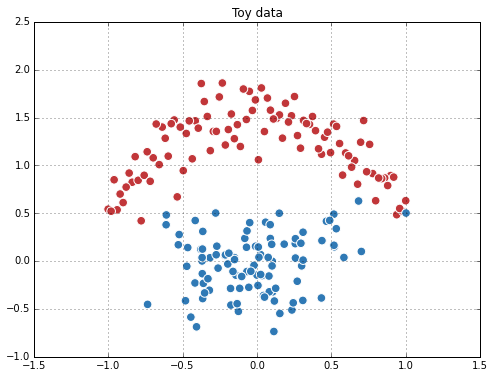

In [62]:
x1 = np.linspace(-1, 1, 100)
x2 = 1.5 - x1 ** 2 + np.random.normal(scale=0.2, size=100)
x3 = np.random.normal(scale=0.3, size=100)
x4 = np.random.normal(scale=0.3, size=100)

permutation = np.random.permutation(np.arange(200))
x = np.hstack((
    np.vstack((x1, x2)),
    np.vstack((x3, x4)))).T[permutation]
y = np.concatenate((
    np.zeros_like(x1),
    np.ones_like(x3)))[permutation]

# needed for pictures later
xx, yy = np.mgrid[-2:2:.01, -2:2:.01]
grid_arr = np.c_[xx.ravel(), yy.ravel()]

def plot_decision(predicts):
    probas = predicts.reshape(xx.shape)

    contour = contourf(xx, yy, probas, 25, cmap="RdBu", vmin=0, vmax=1)
    colorbar(contour)

    scatter(x[:,0], x[:, 1], c=y, s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)
    title("Some cool decision boundary")
    grid()
    
scatter(x[:,0], x[:, 1], c=y, s=75,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
title("Toy data")
grid()

### Logistic regression

In [86]:
# allocate parameters
W = theano.shared(
    value=numpy.zeros((2, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b
p_y_given_x = T.nnet.sigmoid(linear)
y_pred = p_y_given_x > 0.5

# define loss-function
loss = T.nnet.binary_crossentropy(p_y_given_x, Y).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    [X, Y],
    [loss],
    updates=updates,
    allow_input_downcast=True
)

predict_proba = theano.function(
    [X],
    p_y_given_x,
    allow_input_downcast=True
)

In [87]:
## SGD is love SGD is life
batch_size = 4

for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = np.mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

[Epoch 000] Train loss: 0.622525
[Epoch 010] Train loss: 0.237486
[Epoch 020] Train loss: 0.174655
[Epoch 030] Train loss: 0.147724
[Epoch 040] Train loss: 0.132243
[Epoch 050] Train loss: 0.121984
[Epoch 060] Train loss: 0.114588
[Epoch 070] Train loss: 0.108950
[Epoch 080] Train loss: 0.104479
[Epoch 090] Train loss: 0.100828
[Epoch 100] Train loss: 0.097777
[Epoch 110] Train loss: 0.095181
[Epoch 120] Train loss: 0.092939
[Epoch 130] Train loss: 0.090979
[Epoch 140] Train loss: 0.089248
[Epoch 150] Train loss: 0.087705
[Epoch 160] Train loss: 0.086318
[Epoch 170] Train loss: 0.085065
[Epoch 180] Train loss: 0.083925
[Epoch 190] Train loss: 0.082882
[Epoch 200] Train loss: 0.081924
[Epoch 210] Train loss: 0.081041
[Epoch 220] Train loss: 0.080222
[Epoch 230] Train loss: 0.079462
[Epoch 240] Train loss: 0.078753
[Epoch 250] Train loss: 0.078090
[Epoch 260] Train loss: 0.077468
[Epoch 270] Train loss: 0.076884
[Epoch 280] Train loss: 0.076334
[Epoch 290] Train loss: 0.075815
[Epoch 300

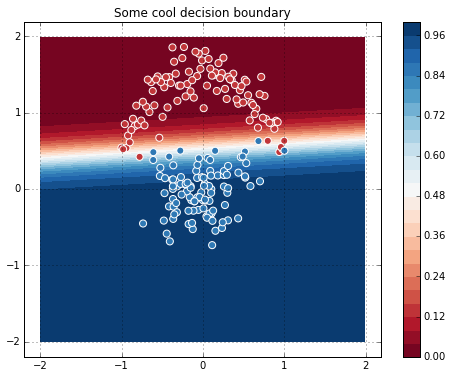

In [83]:
probas = predict_proba(grid_arr)
plot_decision(probas)

### SVM

In [96]:
# reset parameters
W.set_value(numpy.zeros((2, 1),dtype=theano.config.floatX),
        borrow=True)

b.set_value(numpy.zeros((1,), dtype=theano.config.floatX),
    borrow=True)

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    [X, Y],
    [loss],
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    [X],
    linear > 0,
    allow_input_downcast=True
)

In [97]:
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = np.mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

[Epoch 000] Train loss: 0.530719
[Epoch 010] Train loss: 0.125924
[Epoch 020] Train loss: 0.106869
[Epoch 030] Train loss: 0.100274
[Epoch 040] Train loss: 0.095611
[Epoch 050] Train loss: 0.092193
[Epoch 060] Train loss: 0.090120
[Epoch 070] Train loss: 0.088257
[Epoch 080] Train loss: 0.088169
[Epoch 090] Train loss: 0.086988
[Epoch 100] Train loss: 0.084946
[Epoch 110] Train loss: 0.084379
[Epoch 120] Train loss: 0.084354
[Epoch 130] Train loss: 0.082558
[Epoch 140] Train loss: 0.082862
[Epoch 150] Train loss: 0.081033
[Epoch 160] Train loss: 0.080373
[Epoch 170] Train loss: 0.080760
[Epoch 180] Train loss: 0.078818
[Epoch 190] Train loss: 0.078179
[Epoch 200] Train loss: 0.077622
[Epoch 210] Train loss: 0.076089
[Epoch 220] Train loss: 0.077565
[Epoch 230] Train loss: 0.075631
[Epoch 240] Train loss: 0.075526
[Epoch 250] Train loss: 0.074750
[Epoch 260] Train loss: 0.076711
[Epoch 270] Train loss: 0.075783
[Epoch 280] Train loss: 0.076496
[Epoch 290] Train loss: 0.074620
[Epoch 300

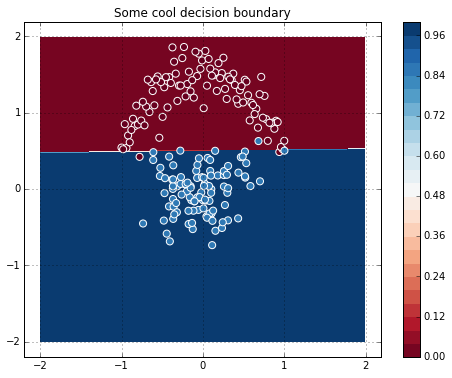

In [98]:
preds = predict(grid_arr)
plot_decision(preds)

In [121]:
coefficients = theano.tensor.vector("coefficients")
x = T.fmatrix("x");
max_coefficients_supported = 3

# Generate the components of the polynomial
full_range=theano.tensor.arange(max_coefficients_supported)
components, updates = theano.scan(fn=lambda power, free_var:
                                   free_var ** power,
                                outputs_info=None,
                                sequences=[full_range],
                                non_sequences=x)
polynomial = components.sum(axis=0)
calculate_polynomial = theano.function(inputs=[x], outputs=polynomial)

In [124]:
theano.printing.debugprint(polynomial)

Sum{axis=[0], acc_dtype=float64} [@A] ''   
 |for{cpu,scan_fn} [@B] ''   
   |Subtensor{int64} [@C] ''   
   | |Shape [@D] ''   
   | | |Subtensor{int64::} [@E] ''   
   | |   |ARange{dtype='int8'} [@F] ''   
   | |   | |TensorConstant{0} [@G]
   | |   | |TensorConstant{3} [@H]
   | |   | |TensorConstant{1} [@I]
   | |   |Constant{0} [@J]
   | |Constant{0} [@K]
   |Subtensor{:int64:} [@L] ''   
   | |Subtensor{int64::} [@E] ''   
   | |ScalarFromTensor [@M] ''   
   |   |Subtensor{int64} [@C] ''   
   |Subtensor{int64} [@C] ''   
   |x [@N]

Inner graphs of the scan ops:

for{cpu,scan_fn} [@B] ''   
 >Elemwise{pow,no_inplace} [@O] ''   
 > |x_copy [@P] -> [@N]
 > |DimShuffle{x,x} [@Q] ''   
 >   |<TensorType(int8, scalar)> [@R] -> [@L]
